<a href="https://colab.research.google.com/github/tamburins/ESAA_2023/blob/main/%EC%88%98%EC%A0%95%EC%A4%91_%EC%B5%9C%EC%A2%85%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/datasets/arushchillar/disneyland-reviews

Column Description:

- **Review_ID**: unique id given to each review
- **Rating**: ranging from 1 (unsatisfied) to 5 (satisfied)
- **Year_Month**: when the reviewer visited the theme park
- **Reviewer_Location**: country of origin of visitor
- **Review_Text**: comments made by visitor
- **Disneyland_Branch**: location of Disneyland Park

목차:

1. 데이터 로드
2. 데이터 전처리
3. 텍스트 데이터 처리
4. 텍스트 데이터 EDA
5. 감성 분석 (Text Blob)
6. 감성 분석 (Vader)
7. 평점별 리뷰 특징 분석
8. 나라별 리뷰 특징 분석
9. 지점별 리뷰 특징 분석

## **데이터 로드**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 압축 파일의 위치(구글 드라이브 - 내 드라이브 위치)
drive_path = "/content/drive/MyDrive/ESAA/OB/project/"
source_filename = drive_path + "Disneyland Reviews/archive.zip"

# 저장할 경로
extract_folder = "dataset/" # 코랩 환경에 임시 저장

# 압축 해제
import shutil
shutil.unpack_archive(source_filename, extract_folder)

In [ ]:
import re   # regrex
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from textblob import TextBlob
from collections import Counter

import warnings
warnings.filterwarnings(action = 'ignore')

In [ ]:
data = pd.read_csv("dataset/DisneylandReviews.csv", encoding='latin-1')
data.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [ ]:
## 임시 데이터
dat = data.copy()
dat.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


## **데이터 전처리**

In [ ]:
## 불필요 변수 제거
dat.drop("Review_ID", axis=1, inplace=True)

In [ ]:
## 날짜 데이터 처리
dat["Year_Month"] = dat["Year_Month"].apply(pd.to_datetime, errors ='coerce') # 날짜 형식 지정
dat.dropna(inplace=True) # 결측치 제거

dat["year"] = dat["Year_Month"].dt.year
dat["month"] = dat["Year_Month"].dt.month

dat.drop("Year_Month", axis=1, inplace=True)

In [ ]:
## Branch 값 단순화
dat["Branch"] = dat["Branch"].apply(lambda x : x.split("_")[1])

In [ ]:
dat.head()

,Rating,Reviewer_Location,Review_Text,Branch,year,month
0,4,Australia,If you've ever been to Disneyland anywhere you...,HongKong,2019,4
1,4,Philippines,Its been a while since d last time we visit HK...,HongKong,2019,5
2,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,HongKong,2019,4
3,4,Australia,HK Disneyland is a great compact park. Unfortu...,HongKong,2019,4
4,4,United Kingdom,"the location is not in the city, took around 1...",HongKong,2019,4


## **텍스트 데이터 처리**

In [ ]:
texts = dat['Review_Text'].values

#=====
processed_texts = []

for sentence in range(0, len(texts)):
    # http: urls 제거
    processed_text = re.sub('(https?://\S+)', '', str(texts[sentence]))

    # 숫자 제거
    processed_text = re.sub(r'\d+',' ',processed_text)

    # 특수문자 제거
    processed_text = re.sub(r'\W', ' ', processed_text)

    # 단일문자 제거
    processed_text= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_text)
    processed_text = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_text)

    # 다중 공백을 단일 공백(띄어쓰기)으로 변경
    processed_text = re.sub(r'\s+', ' ', processed_text, flags=re.I)

    # 이메일 삭제
    processed_text =re.sub(r'[\w\.-]+@[\w\.-]+', '', processed_text)

    # 소문자로 변환
    processed_text = processed_text.lower()

    # 축약 표현 처리
    processed_text = re.sub(r"i'm","i am",processed_text)
    processed_text = re.sub(r"he's","he is",processed_text)
    processed_text = re.sub(r"she's","she is",processed_text)
    processed_text = re.sub(r"that's","that is",processed_text)
    processed_text = re.sub(r"what's","what is",processed_text)
    processed_text = re.sub(r"where's","where is",processed_text)
    processed_text = re.sub(r"\'ll"," will",processed_text)
    processed_text = re.sub(r"\'ve"," have",processed_text)
    processed_text = re.sub(r"youve","you have",processed_text)
    processed_text = re.sub(r"\'re"," are",processed_text)
    processed_text = re.sub(r"\'d"," would",processed_text)
    processed_text = re.sub(r"won't","will not",processed_text)
    processed_text = re.sub(r"can't","cannot",processed_text)

    processed_texts.append(processed_text)
#=====

dat['Processed_Text'] = processed_texts
dat.head()

,Rating,Reviewer_Location,Review_Text,Branch,year,month,Processed_Text
0,4,Australia,If you've ever been to Disneyland anywhere you...,HongKong,2019,4,if you ve ever been to disneyland anywhere you...
1,4,Philippines,Its been a while since d last time we visit HK...,HongKong,2019,5,its been while since last time we visit hk dis...
2,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,HongKong,2019,4,thanks god it wasn too hot or too humid when w...
3,4,Australia,HK Disneyland is a great compact park. Unfortu...,HongKong,2019,4,hk disneyland is great compact park unfortunat...
4,4,United Kingdom,"the location is not in the city, took around 1...",HongKong,2019,4,the location is not in the city took around ho...


## **텍스트 데이터 EDA**

추가적으로 성능 향상을 위한 전처리를 위해 앞서 전처리 된 리뷰 텍스트를 확인한다.

**Stopword 삭제**

In [ ]:
from textblob import Word
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

stop = stopwords.words('english')
dat['EDA_Text'] = dat['Processed_Text'].apply(lambda x : ' '.join(x for x in x.split() if x not in stop))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**Lemmatization**

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
dat['EDA_Text'] = dat['EDA_Text'].apply(lambda x : " ".join(lemmatizer.lemmatize(word) for word in x.split()))

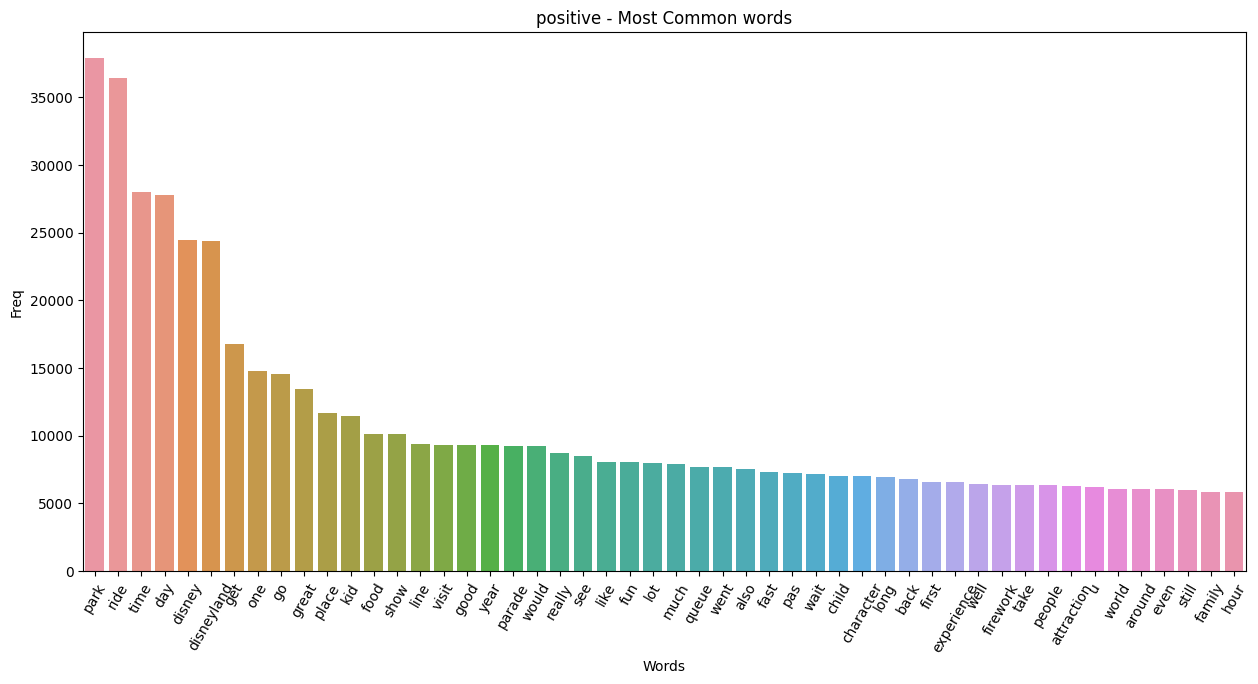

In [ ]:
# 긍정적 리뷰에서 빈도 높은 단어
pos_data = dat[dat['Rating'] >= 4]
most_common = Counter(' '.join(pos_data['EDA_Text']).split()).most_common(50)
pos_df = pd.DataFrame(most_common, columns = ['Words', 'Freq'])

plt.figure(figsize = (15,7))
sns.barplot(data = pos_df, x = 'Words', y = 'Freq')
plt.title('positive - Most Common words')
plt.xticks(rotation = 60)
plt.show()

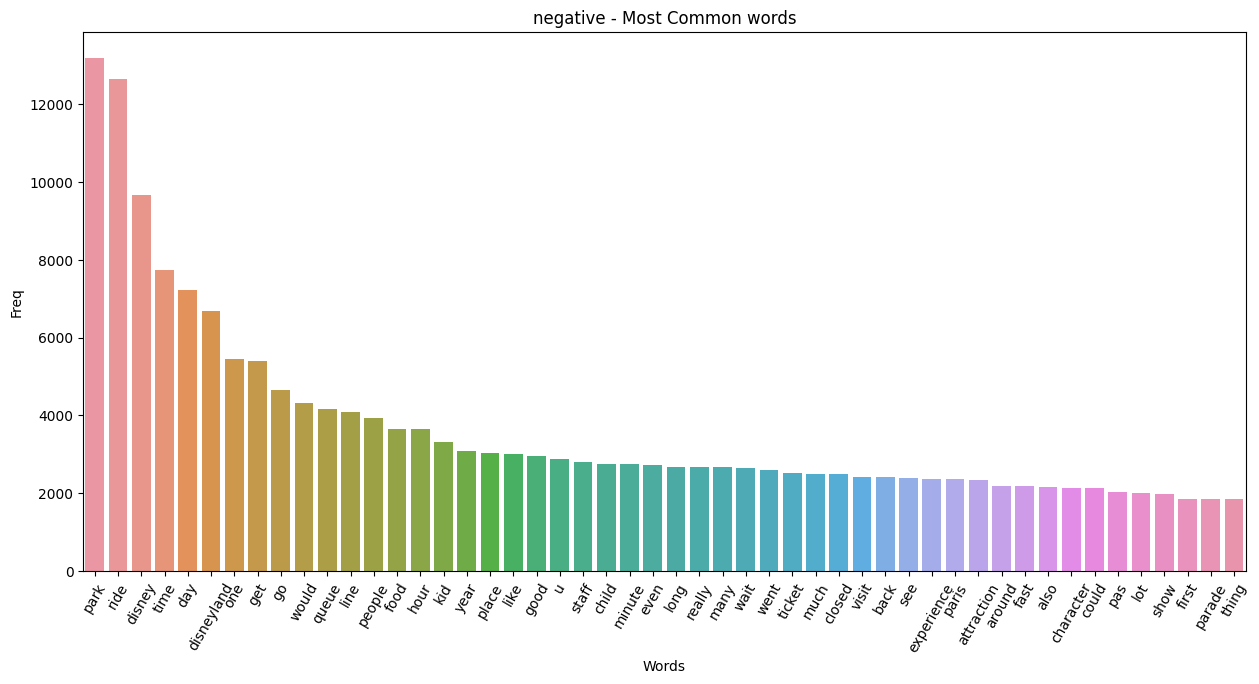

In [ ]:
# 부정적 리뷰에서 빈도 높은 단어
neg_data = dat[dat['Rating'] <= 3]
most_common = Counter(' '.join(neg_data['EDA_Text']).split()).most_common(50)
neg_df = pd.DataFrame(most_common, columns = ['Words', 'Freq'])

plt.figure(figsize = (15,7))
sns.barplot(data = neg_df, x = 'Words', y = 'Freq')
plt.title('negative - Most Common words')
plt.xticks(rotation = 60)
plt.show()

In [ ]:
# 두 그룹에 동시에 존재하는 단어를 확인
common_words = set(neg_df['Words']).intersection(set(pos_df['Words']))
common_words

{'also',
 'around',
 'attraction',
 'back',
 'character',
 'child',
 'day',
 'disney',
 'disneyland',
 'even',
 'experience',
 'fast',
 'first',
 'food',
 'get',
 'go',
 'good',
 'hour',
 'kid',
 'like',
 'line',
 'long',
 'lot',
 'much',
 'one',
 'parade',
 'park',
 'pas',
 'people',
 'place',
 'queue',
 'really',
 'ride',
 'see',
 'show',
 'time',
 'u',
 'visit',
 'wait',
 'went',
 'would',
 'year'}

In [ ]:
# 두 그룹에 동시에 존재하지 않는 단어 추출
neg_words = set(neg_df['Words'])
pos_words = set(pos_df['Words'])

exclusive_to_neg = neg_words.difference(pos_words)
exclusive_to_pos = pos_words.difference(neg_words)

print('neg에만 높은 빈도로 존재하는 단어들 : ',exclusive_to_neg)
print('pos에만 높은 빈도로 존재하는 단어들 : ',exclusive_to_pos)

neg에만 높은 빈도로 존재하는 단어들 :  {'thing', 'closed', 'could', 'staff', 'many', 'minute', 'paris', 'ticket'}
pos에만 높은 빈도로 존재하는 단어들 :  {'well', 'world', 'great', 'take', 'family', 'still', 'firework', 'fun'}


동시에 존재하는 단어가 많이 존재하지만, 리뷰 텍스트로 분류 모델을 개발할 때는 정보 손실의 문제가 있어 동시 존재 단어 제거에 주의해야한다.

문맥 고려에 중요한 역할을 하는 단어들일 수도 있기 때문에 이를 바로 제거하는 것은 옳지 않다.

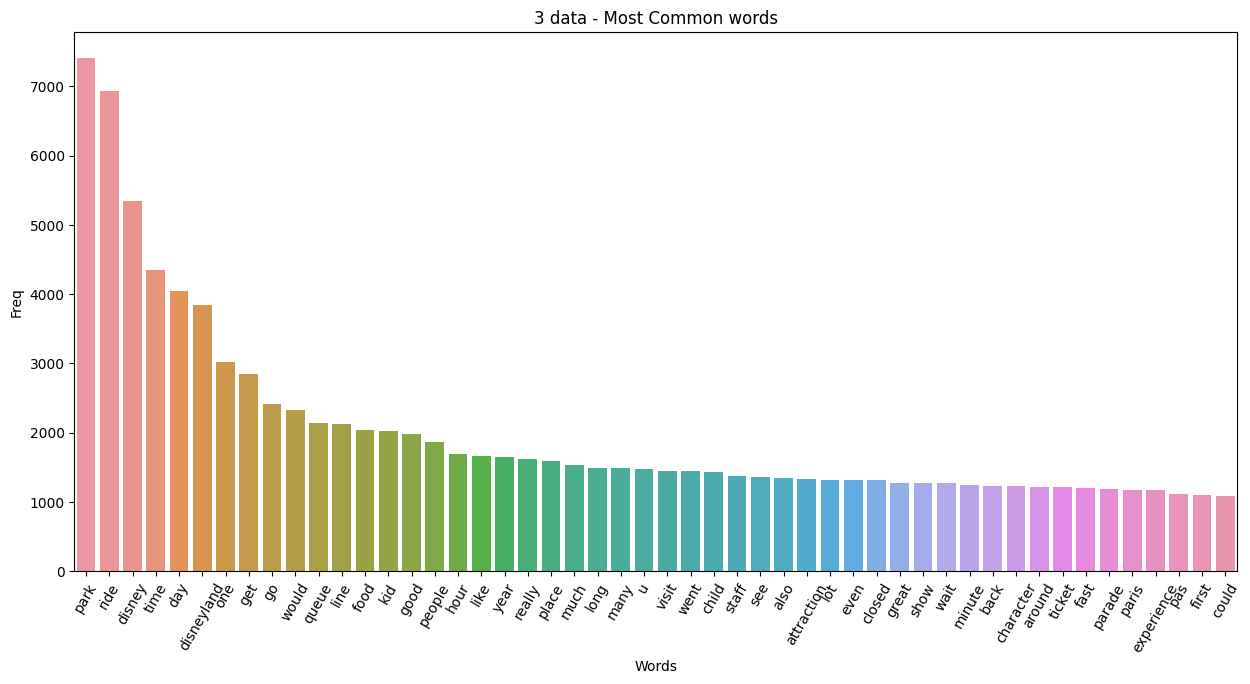

In [ ]:
# 3점 데이터 경향성 확인
data_3 = dat[dat['Rating'] == 3]
most_common = Counter(' '.join(data_3['EDA_Text']).split()).most_common(50)
df_3 = pd.DataFrame(most_common, columns = ['Words', 'Freq'])

plt.figure(figsize = (15,7))
sns.barplot(data = df_3, x = 'Words', y = 'Freq')
plt.title('3 data - Most Common words')
plt.xticks(rotation = 60)
plt.show()

In [ ]:
words_3 = set(df_3['Words'])

unexclusive_to_neg = words_3.difference(neg_words)
unexclusive_to_pos = words_3.difference(pos_words)

print('부정적에는 없고, 3점에만 있는 단어들 : ',unexclusive_to_neg)
print('긍정적에는 없고, 3점에만 있는 단어들 : ',unexclusive_to_pos)

부정적에는 없고, 3점에만 있는 단어들 :  {'great'}
긍정적에는 없고, 3점에만 있는 단어들 :  {'closed', 'could', 'staff', 'many', 'minute', 'paris', 'ticket'}


## **감성 분석 (Text Blob)**

In [ ]:
# 극성 점수
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity

dat['Polarity'] = dat['Processed_Text'].apply(getPolarity)

In [ ]:
## 정답 레이블
# Rating 3 이하 → Negative로 분류
dat['Sentiment'] = dat['Rating'].apply(lambda x: 'Negative' if x <= 3 else 'Positive')
dat['Sentiment'].value_counts()

Positive    31994
Negative     8049
Name: Sentiment, dtype: int64

**분석**

In [ ]:
## 예측 레이블
# 극성 점수 < 0 → Negative로 분류
def getAnalysis(score):
 if score < 0:
  return 'Negative'
 else:
  return 'Positive'

dat['Analysis'] = dat['Polarity'].apply(getAnalysis)

**결과 비교**

In [ ]:
dat['Result'] = dat.apply(lambda row: 'Correct' if row['Analysis'] == row['Sentiment'] else 'Incorrect', axis = 1)
dat['Result'].value_counts()

Correct      32897
Incorrect     7146
Name: Result, dtype: int64

In [ ]:
# 맞춘 비율
len(dat[dat['Result']=='Correct'])/len(dat)

0.8215418425192917

In [ ]:
# Negative를 Negative로 잘 분류한 비율
dat_Neg = dat[dat['Sentiment']=='Negative']
len(dat_Neg[dat_Neg['Analysis']=='Negative'])/len(dat_Neg)

0.27431979127841966

In [ ]:
# Positve를 Positive로 잘 분류한 비율
dat_Pos = dat[dat['Sentiment']=='Positive']
len(dat_Pos[dat_Pos['Analysis']=='Positive'])/len(dat_Pos)

0.9592111020816403

In [ ]:
# 실제론 Negative인데 Positive로 잘못 분류한 비율
dat_Neg = dat[dat['Sentiment']=='Negative']
len(dat_Neg[dat_Neg['Analysis']=='Positive'])/len(dat_Neg)

0.7256802087215803

In [ ]:
# 실제론 Positive인데 Negative로 잘못 분류한 비율
dat_Pos = dat[dat['Sentiment']=='Positive']
len(dat_Pos[dat_Pos['Analysis']=='Negative'])/len(dat_Pos)

0.04078889791835969

In [ ]:
# Incorrect
incorrect_index = dat.loc[dat['Result'] == 'Incorrect'].index
incorrect_data = dat.loc[incorrect_index]
incorrect_data[['Rating','Review_Text','Polarity','Sentiment','Analysis','Result']]

,Rating,Review_Text,Polarity,Sentiment,Analysis,Result
7,3,Think of it as an intro to Disney magic for th...,0.054722,Negative,Positive,Incorrect
21,3,First off I'm not a really big Disneyland fan....,0.201256,Negative,Positive,Incorrect
22,3,Mickey and the Wounderous book was great and t...,0.306687,Negative,Positive,Incorrect
23,3,I ve been to Hong Kong Disneyland twice and ...,0.102803,Negative,Positive,Incorrect
25,3,Disneylands the world over are generic apart f...,0.060000,Negative,Positive,Incorrect
...,...,...,...,...,...,...
42098,1,"250 total for tickets, parking and food for...",0.053563,Negative,Positive,Incorrect
42104,1,I was thrilled to check out a Disney park outs...,0.087500,Negative,Positive,Incorrect
42108,3,I just wanted to post a word of warning about ...,0.137500,Negative,Positive,Incorrect
42115,1,We spent the 20 Dec 2010 in the Disney park an...,0.020628,Negative,Positive,Incorrect


## **감성 분석 (Vader)**

소셜 미디어 감성 분석 용도로 만들어진 Lexicon
- 'neg'는 부정 감성 지수, 'neu'는 중립적인 감성 지수, 'pos'는 긍정 감성 지수
- compound는 neg, neu, pos score를 적절히 조합해 -1에서 1사이의 감성 지수를 표현한 값
  - compound score를 기반으로 부정 감성 또는 긍정 감성 여부를 결정
  - 보통 0.1 이상이면 긍정 감성, 그 이하이면 부정감성으로 판단하나 상황에 따라 이 임계값을 적절히 조정해 예측 성능을 조절

In [ ]:
# 긍정/부정 예측 함수
def Vader_Polarity(text, threshold = 0.1):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer

    # VADER 객체로 감성 지수 산출
    analyzer = SentimentIntensityAnalyzer()
    score = analyzer.polarity_scores(text)

    # 감성 지수가 threshold 보다 크거나 같으면 Positive, 그렇지 않으면 Negative
    vader_score = score['compound']
    vader_sentiment = 'Positive' if vader_score >= threshold else 'Negative'

    return vader_sentiment

**분석**

In [ ]:
# 긍정/부정 예측
dat['Vader_Analysis'] = dat['Processed_Text'].apply(lambda x : Vader_Polarity(x, 0.1))

In [ ]:
dat['Vader_Analysis']

0        Positive
1        Positive
2        Positive
3        Positive
4        Positive
           ...   
42113    Negative
42114    Positive
42115    Positive
42116    Positive
42117    Positive
Name: Vader_Analysis, Length: 40043, dtype: object

**결과 비교**

In [ ]:
dat['Vader_Result'] = dat.apply(lambda row: 'Correct' if row['Vader_Analysis'] == row['Sentiment'] else 'Incorrect', axis = 1)
dat['Vader_Result'].value_counts()

Correct      32938
Incorrect     7105
Name: Vader_Result, dtype: int64

In [ ]:
# 맞춘 비율
len(dat[dat['Vader_Result']=='Correct'])/len(dat)

0.8225657418275354

In [ ]:
# Negative를 Negative로 잘 분류한 비율
dat_Neg = dat[dat['Sentiment']=='Negative']
len(dat_Neg[dat_Neg['Vader_Analysis']=='Negative'])/len(dat_Neg)

0.35333581811405146

In [ ]:
# Positve를 Positive로 잘 분류한 비율
dat_Pos = dat[dat['Sentiment']=='Positive']
len(dat_Pos[dat_Pos['Vader_Analysis']=='Positive'])/len(dat_Pos)

0.9406138650997062

In [ ]:
# 실제론 Negative인데 Positive로 잘못 분류한 비율
dat_Neg = dat[dat['Sentiment']=='Negative']
len(dat_Neg[dat_Neg['Vader_Analysis']=='Positive'])/len(dat_Neg)

0.6466641818859485

In [ ]:
# 실제론 Positive인데 Negative로 잘못 분류한 비율
dat_Pos = dat[dat['Sentiment']=='Positive']
len(dat_Pos[dat_Pos['Vader_Analysis']=='Negative'])/len(dat_Pos)

0.059386134900293805

## **평점별 리뷰 특징 분석**

In [ ]:
df_Pos = dat[(dat['Rating']==4) | (dat['Rating']==5)]
df_Neg = dat[(dat['Rating']==1) | (dat['Rating']==2)]

In [ ]:
!pip install wordcloud

from wordcloud import WordCloud
from wordcloud import STOPWORDS

In [ ]:
text_Pos = " ".join(i for i in df_Pos.EDA_Text)

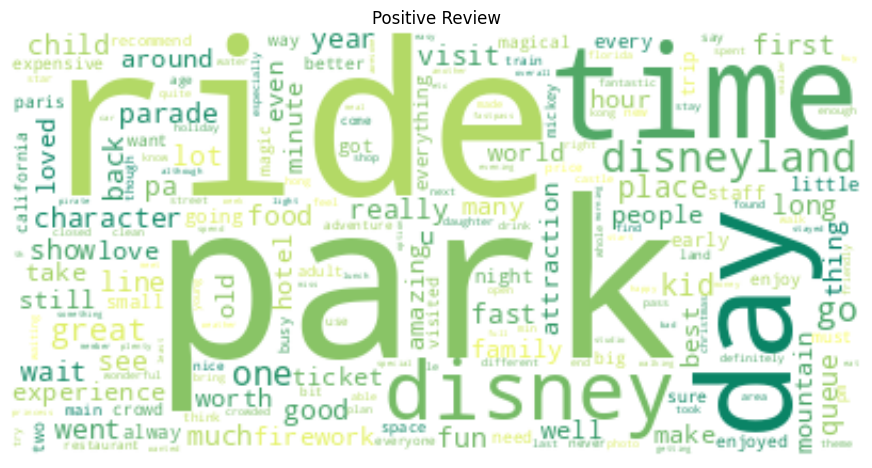

In [ ]:
wordcloud_Pos = WordCloud(
    colormap="summer", background_color = 'white',
    collocations=False).generate(text_Pos)

plt.figure(figsize=[11,11])
plt.imshow(wordcloud_Pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Review")
plt.show()

In [ ]:
text_Neg = " ".join(i for i in df_Neg.EDA_Text)

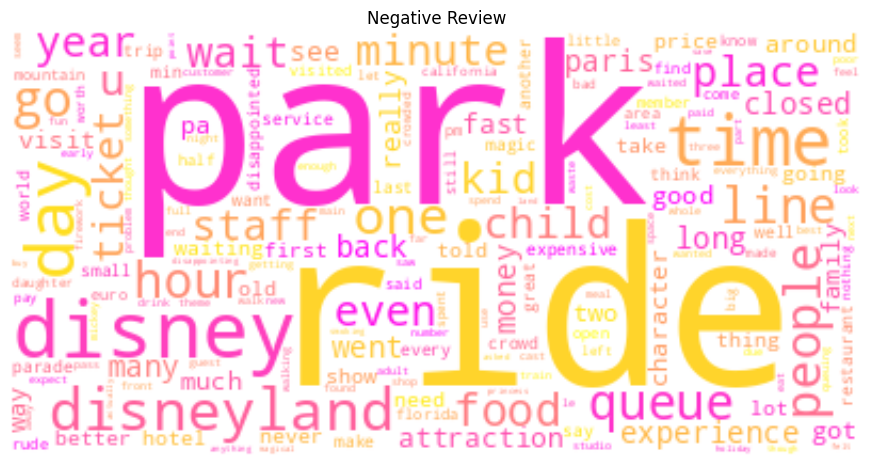

In [ ]:
wordcloud_Neg = WordCloud(
    colormap="spring", background_color = 'white',
    collocations=False).generate(text_Neg)

plt.figure(figsize=[11,11])
plt.imshow(wordcloud_Neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Review")
plt.show()

In [ ]:
df_rate1 = dat[dat['Rating']==1]
df_rate2 = dat[dat['Rating']==2]
df_rate3 = dat[dat['Rating']==3]
df_rate4 = dat[dat['Rating']==4]
df_rate5 = dat[dat['Rating']==5]

In [ ]:
stop3 = ['disney','park','time','ride','day','days','disneyland','parks','rides','get','go','one','went', 'u']

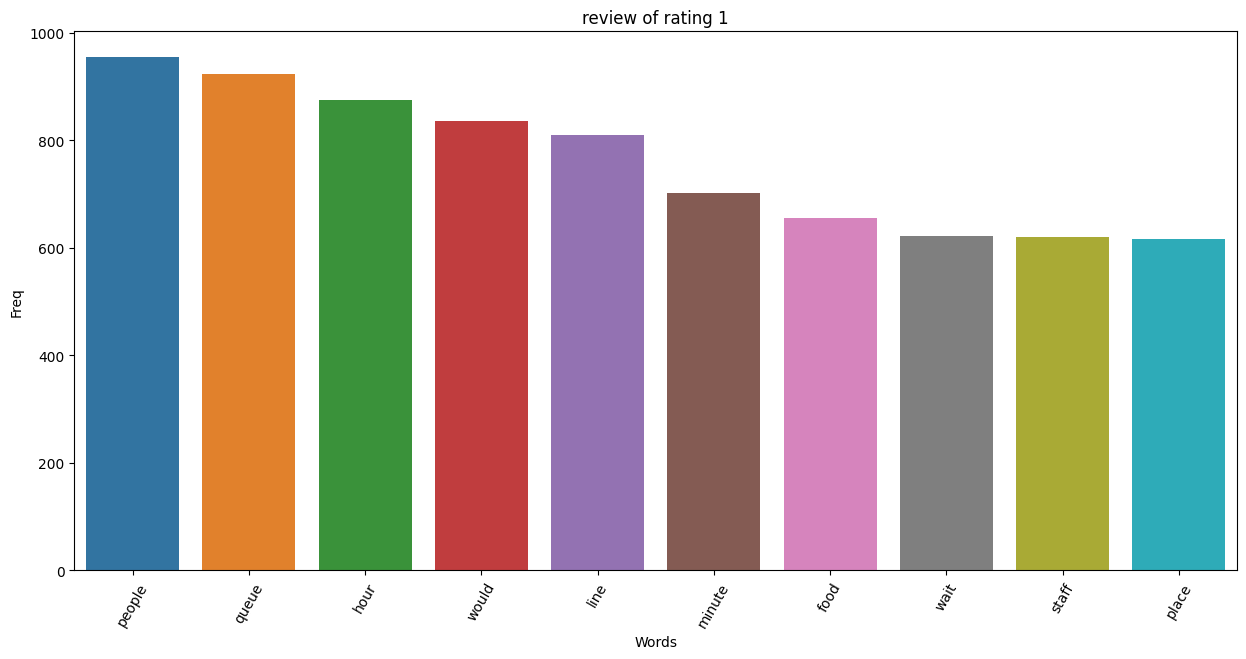

In [ ]:
df_rate1['EDA_Text'] = df_rate1['EDA_Text'].apply(lambda x : " ".join(x for x in x.split() if x not in (stop + stop3)))
most_common = Counter(' '.join(df_rate1['EDA_Text']).split()).most_common(10)
mco_df1 = pd.DataFrame(most_common, columns = ['Words', 'Freq'])
plt.figure(figsize = (15,7))
sns.barplot(data = mco_df1, x = 'Words', y = 'Freq')
plt.title('review of rating 1')
plt.xticks(rotation = 60)
plt.show()

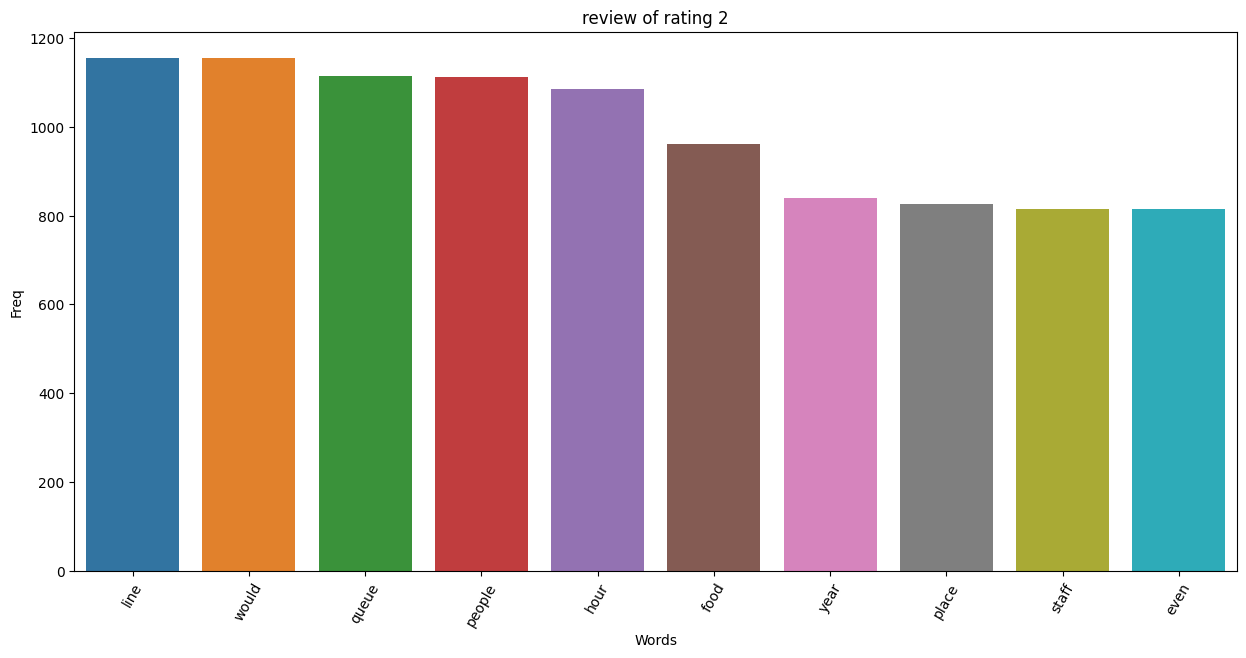

In [ ]:
df_rate2['EDA_Text'] = df_rate2['EDA_Text'].apply(lambda x : " ".join(x for x in x.split() if x not in (stop + stop3)))
most_common = Counter(' '.join(df_rate2['EDA_Text']).split()).most_common(10)
mco_df2 = pd.DataFrame(most_common, columns = ['Words', 'Freq'])
plt.figure(figsize = (15,7))
sns.barplot(data = mco_df2, x = 'Words', y = 'Freq')
plt.title('review of rating 2')
plt.xticks(rotation = 60)
plt.show()

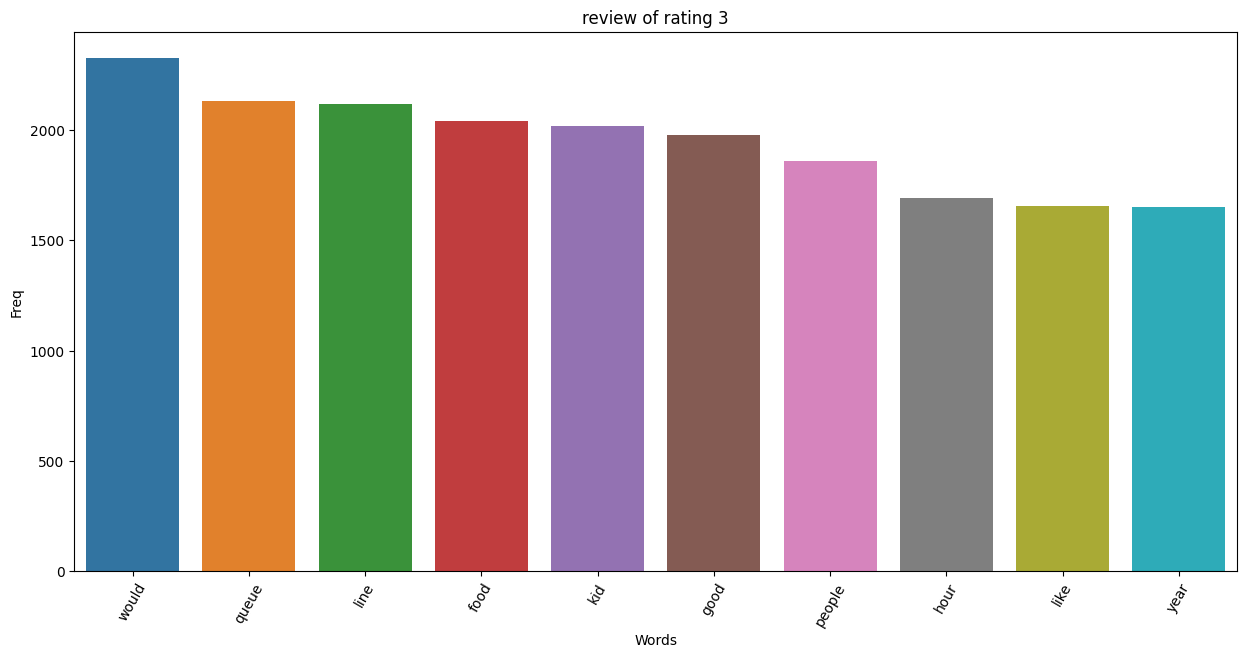

In [ ]:
df_rate3['EDA_Text'] = df_rate3['EDA_Text'].apply(lambda x : " ".join(x for x in x.split() if x not in (stop + stop3)))
most_common = Counter(' '.join(df_rate3['EDA_Text']).split()).most_common(10)
mco_df3 = pd.DataFrame(most_common, columns = ['Words', 'Freq'])
plt.figure(figsize = (15,7))
sns.barplot(data = mco_df3, x = 'Words', y = 'Freq')
plt.title('review of rating 3')
plt.xticks(rotation = 60)
plt.show()

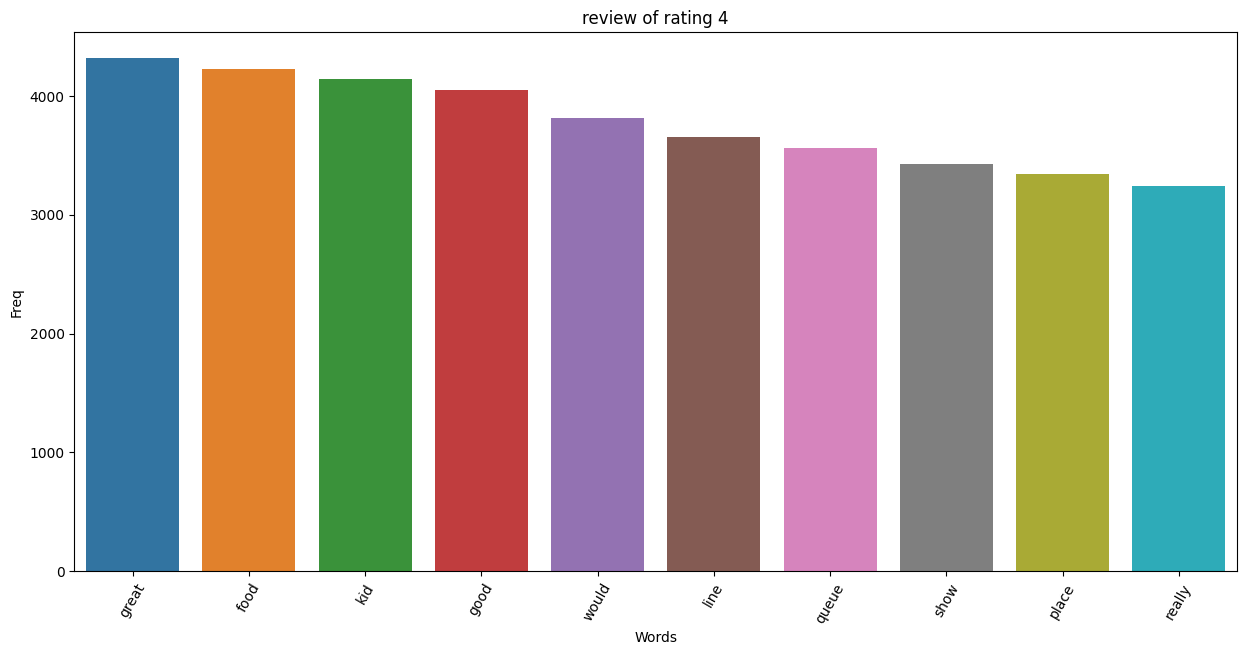

In [ ]:
df_rate4['EDA_Text'] = df_rate4['EDA_Text'].apply(lambda x : " ".join(x for x in x.split() if x not in (stop + stop3)))
most_common = Counter(' '.join(df_rate4['EDA_Text']).split()).most_common(10)
mco_df4 = pd.DataFrame(most_common, columns = ['Words', 'Freq'])
plt.figure(figsize = (15,7))
sns.barplot(data = mco_df4, x = 'Words', y = 'Freq')
plt.title('review of rating 4')
plt.xticks(rotation = 60)
plt.show()

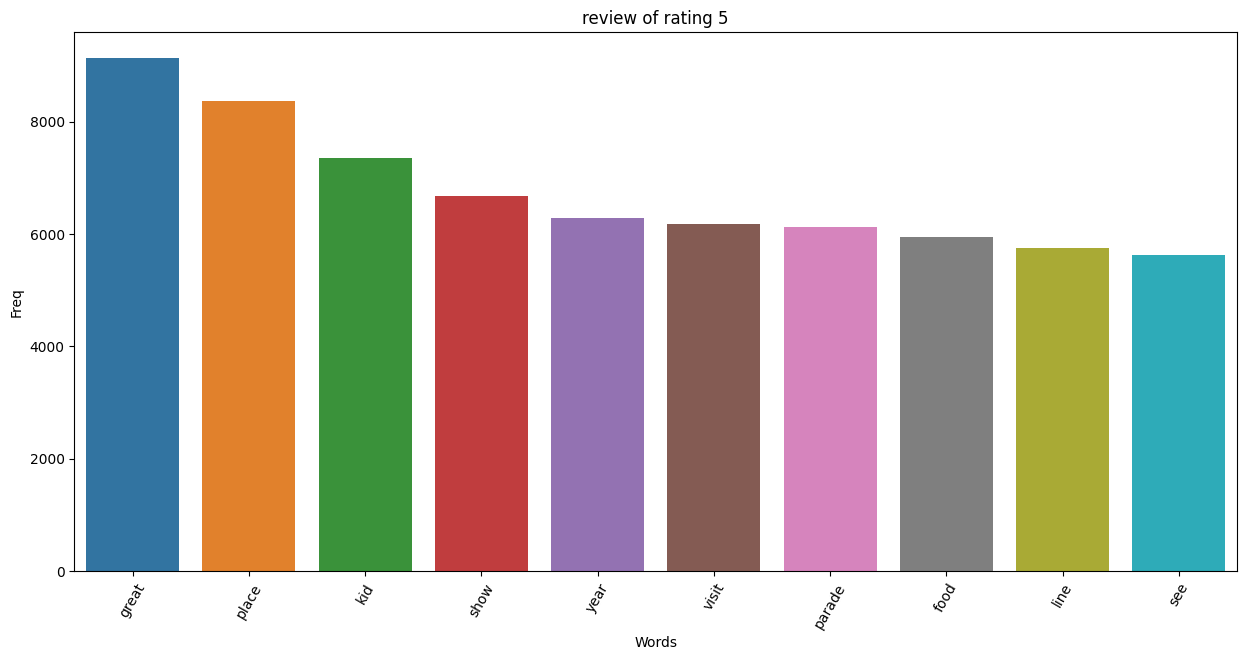

In [ ]:
df_rate5['EDA_Text'] = df_rate5['EDA_Text'].apply(lambda x : " ".join(x for x in x.split() if x not in (stop + stop3)))
most_common = Counter(' '.join(df_rate5['EDA_Text']).split()).most_common(10)
mco_df5 = pd.DataFrame(most_common, columns = ['Words', 'Freq'])
plt.figure(figsize = (15,7))
sns.barplot(data = mco_df5, x = 'Words', y = 'Freq')
plt.title('review of rating 5')
plt.xticks(rotation = 60)
plt.show()

- 1~2점대 리뷰
  + people
  + long
  + wait
  + closed
  + staff

- 3점대 리뷰
  + food, long, people
  + really, kids, good, like

- 4~5점대 리뷰
  + great
  + kids
  + fun
  + good
  + really

> - 전반적으로 부정적인 리뷰는 긴 대기시간, 어트랙션 미운영, 스태프나 음식에 대한 불만에 대한 내용이 많고 긍정적인 리뷰는 아이나 즐거운 경험에 대한 내용이 많아 보인다
- 특히 3점대는 긍정/부정 리뷰에서 자주 등장하는 단어가 적절히 섞여있는 것으로 보아 개인의 성향에 따라 긍정적일수도, 부정적일수도 있다. 긍정+부정의 리뷰인 경우가 종종 보인다. (긍정적인 리뷰+아쉬운점 / 부정적인 리뷰+좋았던점)


In [ ]:
stop4 = ['disney','park','time','ride','day','days','disneyland','parks','rides','get','go','one','went','place','would','visit','people', 'u']

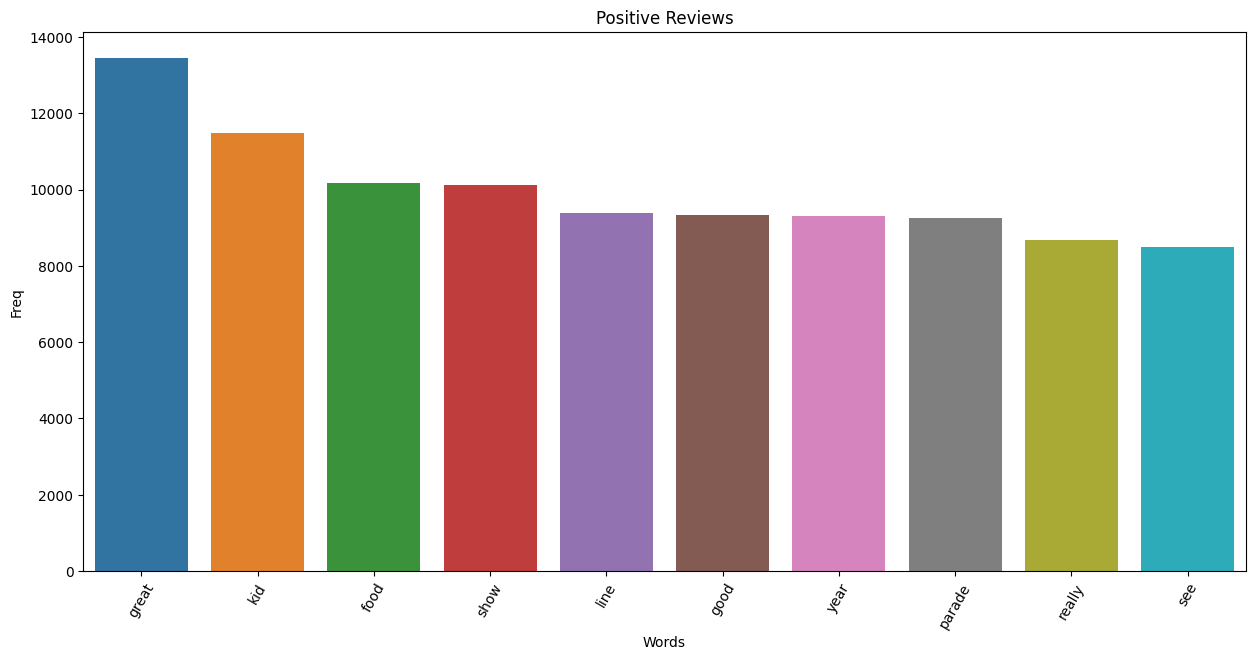

In [ ]:
df_Pos['EDA_Text'] = df_Pos['EDA_Text'].apply(lambda x : " ".join(x for x in x.split() if x not in (stop + stop4)))
most_common = Counter(' '.join(df_Pos['EDA_Text']).split()).most_common(10)
mco_df_Pos = pd.DataFrame(most_common, columns = ['Words', 'Freq'])
plt.figure(figsize = (15,7))
sns.barplot(data = mco_df_Pos, x = 'Words', y = 'Freq')
plt.title('Positive Reviews')
plt.xticks(rotation = 60)
plt.show()

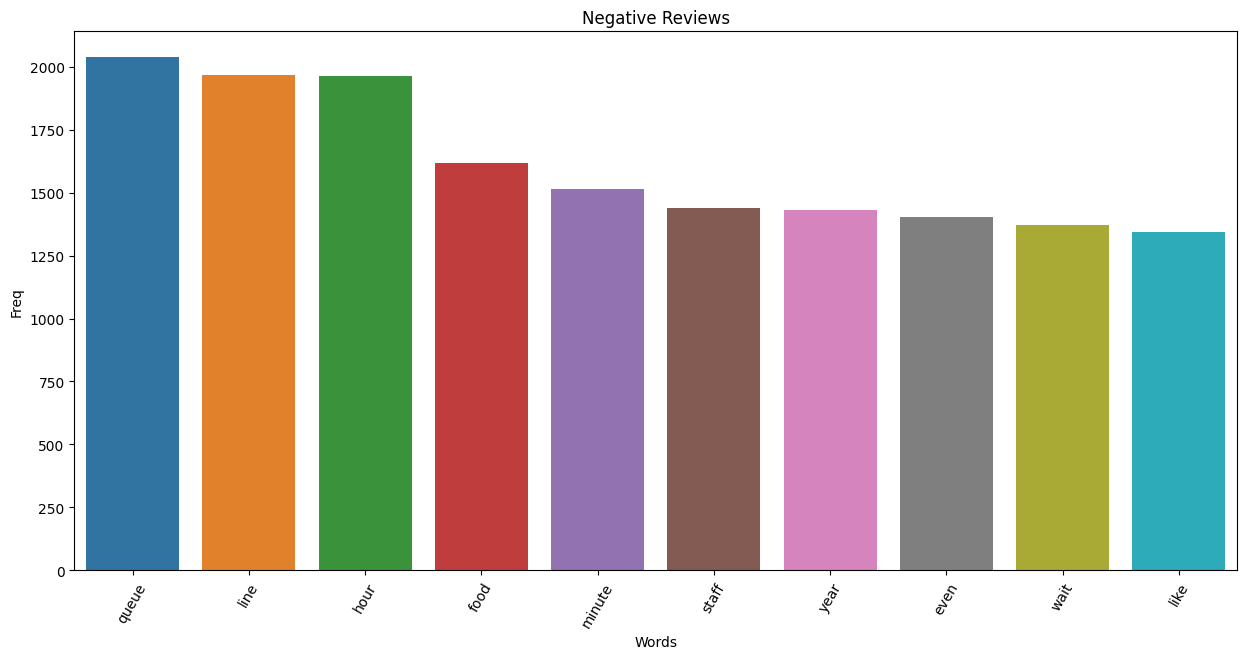

In [ ]:
df_Neg['EDA_Text'] = df_Neg['EDA_Text'].apply(lambda x : " ".join(x for x in x.split() if x not in (stop + stop4)))
most_common = Counter(' '.join(df_Neg['EDA_Text']).split()).most_common(10)
mco_df_Neg = pd.DataFrame(most_common, columns = ['Words', 'Freq'])
plt.figure(figsize = (15,7))
sns.barplot(data = mco_df_Neg, x = 'Words', y = 'Freq')
plt.title('Negative Reviews')
plt.xticks(rotation = 60)
plt.show()

## **나라별 리뷰 특징 분석**

In [ ]:
dat['Reviewer_Location'].value_counts()

United States               13522
United Kingdom               9115
Australia                    4412
Canada                       2116
India                        1470
                            ...  
Turks and Caicos Islands        1
Timor-Leste                     1
South Sudan                     1
Curaçao                         1
Andorra                         1
Name: Reviewer_Location, Length: 162, dtype: int64

In [ ]:
# 리뷰수 적은 국가 제외 (평균 기준)
Locat = pd.DataFrame(dat['Reviewer_Location'].value_counts() > dat['Reviewer_Location'].value_counts().mean())
Locat = Locat[Locat['Reviewer_Location']==True].index

df1 = dat[dat['Reviewer_Location'].apply(lambda x: x in Locat)]
df1.head()

,Rating,Reviewer_Location,Review_Text,Branch,year,month,Processed_Text,EDA_Text,Polarity,Sentiment,Analysis,Result
0,4,Australia,If you've ever been to Disneyland anywhere you...,HongKong,2019,4,if you ve ever been to disneyland anywhere you...,ever disneyland anywhere find disneyland hong ...,0.239352,Positive,Positive,Correct
1,4,Philippines,Its been a while since d last time we visit HK...,HongKong,2019,5,its been while since last time we visit hk dis...,since last time visit hk disneyland yet time s...,0.205797,Positive,Positive,Correct
2,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,HongKong,2019,4,thanks god it wasn too hot or too humid when w...,thanks god hot humid visiting park otherwise w...,0.119238,Positive,Positive,Correct
3,4,Australia,HK Disneyland is a great compact park. Unfortu...,HongKong,2019,4,hk disneyland is great compact park unfortunat...,hk disneyland great compact park unfortunately...,0.189286,Positive,Positive,Correct
4,4,United Kingdom,"the location is not in the city, took around 1...",HongKong,2019,4,the location is not in the city took around ho...,location city took around hour kowlon kids lik...,0.266667,Positive,Positive,Correct


In [ ]:
df1 = df1.groupby(['Reviewer_Location'],as_index=False).agg({'Rating':'mean'}).sort_values(by='Rating', ascending=True)
df1.style.background_gradient(cmap="autumn", subset=['Rating'])

,Reviewer_Location,Rating
2,Hong Kong,3.834951
9,Singapore,4.024717
11,United Kingdom,4.069885
10,United Arab Emirates,4.215339
6,Malaysia,4.241993
5,Ireland,4.245614
1,Canada,4.298677
0,Australia,4.317543
4,Indonesia,4.322896
12,United States,4.331756


- Hong Kong: 상대적으로 점수 낮게 주는 경향을 보인다.
- India: 상대적으로 점수 높게 주는 경향을 보인다.

<Axes: ylabel='Rating'>

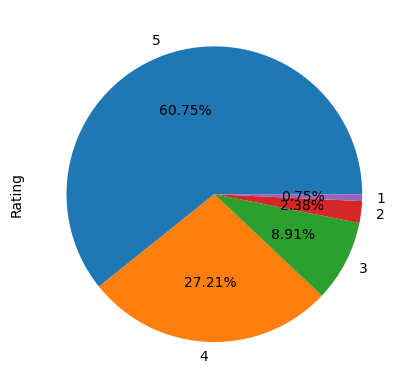

In [ ]:
# India (상대적으로 점수 높게 주는 국가)
Rat_India = dat[dat['Reviewer_Location']=='India'].Rating.value_counts()
Rat_India.plot.pie(autopct='%.2f%%')

<Axes: ylabel='Rating'>

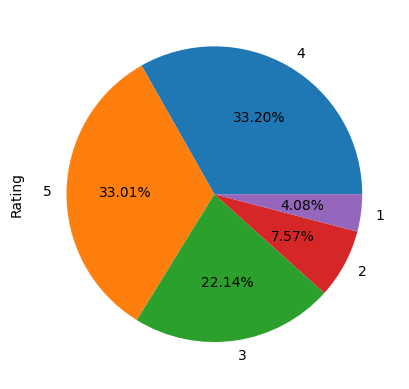

In [ ]:
# HongKong (상대적으로 점수 낮게 주는 국가)
Rat_HongKong = dat[dat['Reviewer_Location']=='Hong Kong'].Rating.value_counts()
Rat_HongKong.plot.pie(autopct='%.2f%%')

## **지점별 리뷰 특징 분석**

In [ ]:
df_Cal = dat.loc[dat['Branch']=='California']
df_Par = dat.loc[dat['Branch']=='Paris']
df_Hong = dat.loc[dat['Branch']=='HongKong']

In [ ]:
stop2 = ['park','parks','disney','disneyland','paris','california','hongkong','would','go','get','like','one','good','u','day', 'pa', 'pas']

In [ ]:
df_Cal['EDA_Text'] = df_Cal['EDA_Text'].apply(lambda x : " ".join(x for x in x.split() if x not in (stop + stop2)))
df_Par['EDA_Text'] = df_Par['EDA_Text'].apply(lambda x : " ".join(x for x in x.split() if x not in (stop + stop2)))
df_Hong['EDA_Text'] = df_Hong['EDA_Text'].apply(lambda x : " ".join(x for x in x.split() if x not in (stop + stop2)))

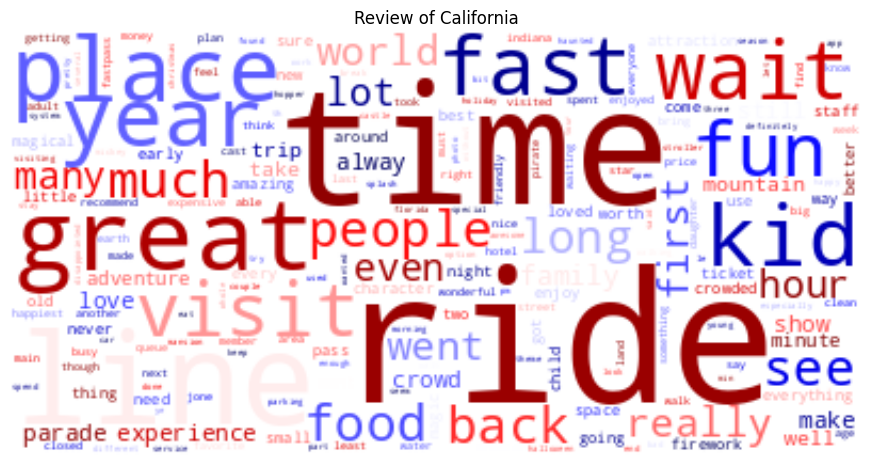

In [ ]:
# wordcloud of California
text_Cal = " ".join(i for i in df_Cal.EDA_Text)

wordcloud_Cal = WordCloud(
    colormap="seismic", background_color = 'white',
    collocations=False).generate(text_Cal)

plt.figure(figsize=[11,11])
plt.imshow(wordcloud_Cal, interpolation="bilinear")
plt.axis("off")
plt.title("Review of California")
plt.show()

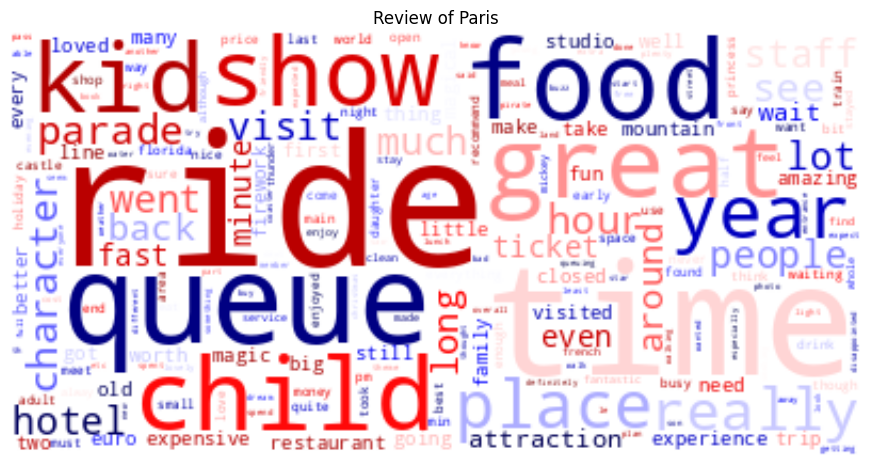

In [ ]:
# wordcloud of Paris
text_Par = " ".join(i for i in df_Par.EDA_Text)

wordcloud_Par = WordCloud(
    colormap="seismic", background_color = 'white',
    collocations=False).generate(text_Par)

plt.figure(figsize=[11,11])
plt.imshow(wordcloud_Par, interpolation="bilinear")
plt.axis("off")
plt.title("Review of Paris")
plt.show()

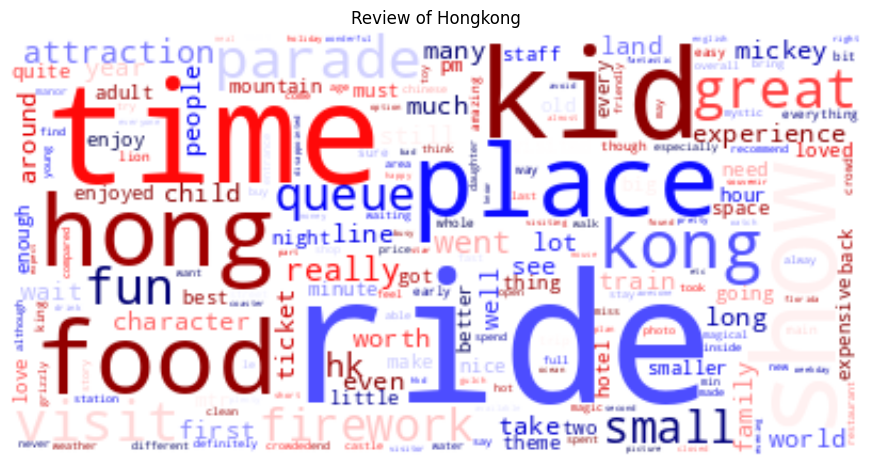

In [ ]:
# wordcloud of Hongkong
text_Hong = " ".join(i for i in df_Hong.EDA_Text)

wordcloud_Hong = WordCloud(
    colormap="seismic", background_color = 'white',
    collocations=False).generate(text_Hong)

plt.figure(figsize=[11,11])
plt.imshow(wordcloud_Hong, interpolation="bilinear")
plt.axis("off")
plt.title("Review of Hongkong")
plt.show()

<Axes: xlabel='Branch', ylabel='count'>

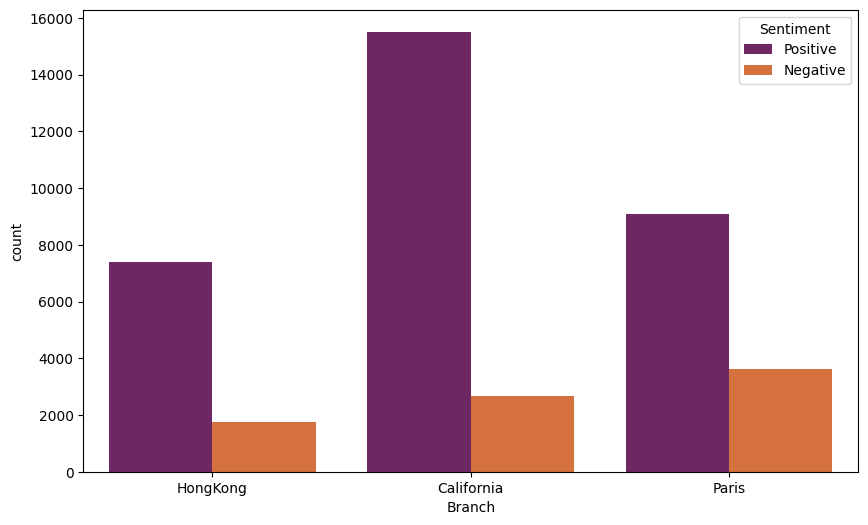

In [ ]:
# 지점별 긍정/부정 빈도 수 비교
plt.figure(figsize=(10,6))
sns.countplot(data=dat,x='Branch',hue='Sentiment',palette='inferno')

Text(0.5, 1.0, 'Paris')

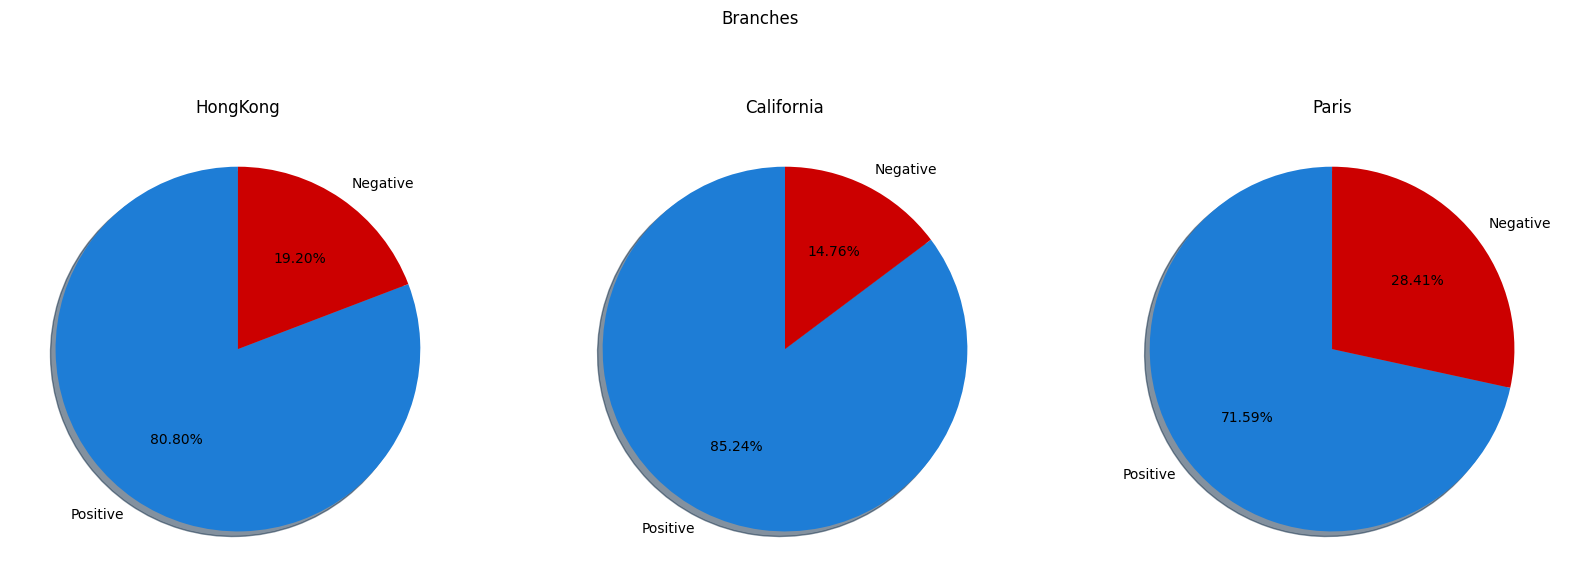

In [ ]:
# 지점별 긍정/부정 비율 비교
label_Cal = df_Cal['Sentiment'].value_counts(sort = True).index
size_Cal = df_Cal['Sentiment'].value_counts(sort = True)

label_Par =df_Par['Sentiment'].value_counts(sort = True).index
size_Par = df_Par['Sentiment'].value_counts(sort = True)

label_Hong = df_Hong['Sentiment'].value_counts(sort = True).index
size_Hong = df_Hong['Sentiment'].value_counts(sort = True)


fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=False)
fig.suptitle('Branches')
axes[0].pie(size_Hong,labels=label_Cal,startangle=90,shadow=1,autopct='%1.2f%%',colors=['#1e7dd6','#CC0000'])
axes[0].set_title('HongKong')
axes[1].pie(size_Cal,labels=label_Par,startangle=90,shadow=1,autopct='%1.2f%%',colors=['#1e7dd6','#CC0000'])
axes[1].set_title('California')
axes[2].pie(size_Par,labels=label_Hong,startangle=90,shadow=1,autopct='%1.2f%%',colors=['#1e7dd6','#CC0000'])
axes[2].set_title('Paris')

- Paris 지점의 Negative 비율이 다른 지점에 비해 상대적으로 높다.

**왜 Paris 지점의 부정 리뷰 비율이 높을까?**

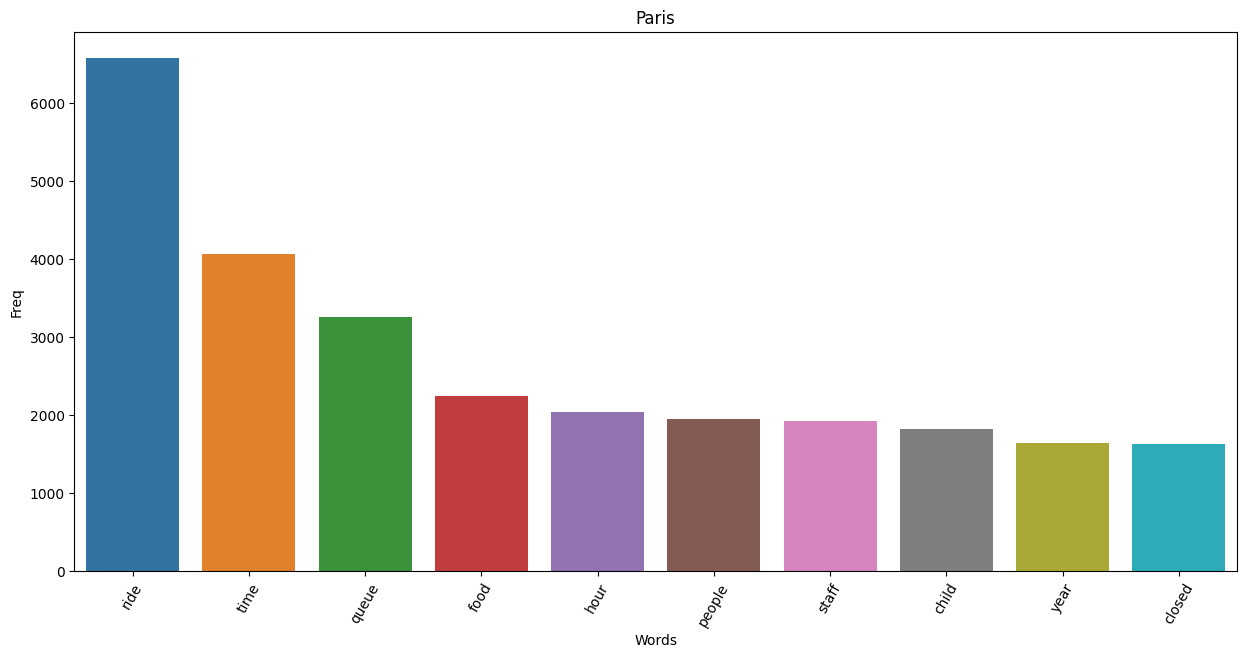

In [ ]:
df_Par_Neg = df_Par[df_Par['Sentiment']=='Negative']
most_common = Counter(' '.join(df_Par_Neg['EDA_Text']).split()).most_common(10)
mco_df = pd.DataFrame(most_common, columns = ['Words', 'Freq'])
plt.figure(figsize = (15,7))
sns.barplot(data = mco_df, x = 'Words', y = 'Freq')
plt.title('Paris')
plt.xticks(rotation = 60)
plt.show()

**Paris**
- food: 음식이 비싸다. 퀄리티가 낮다.
- staff: 스태프 수 부족, 태도 지적 (교육 부족, 불친절)
- closed: 운영 중단된 놀이기구

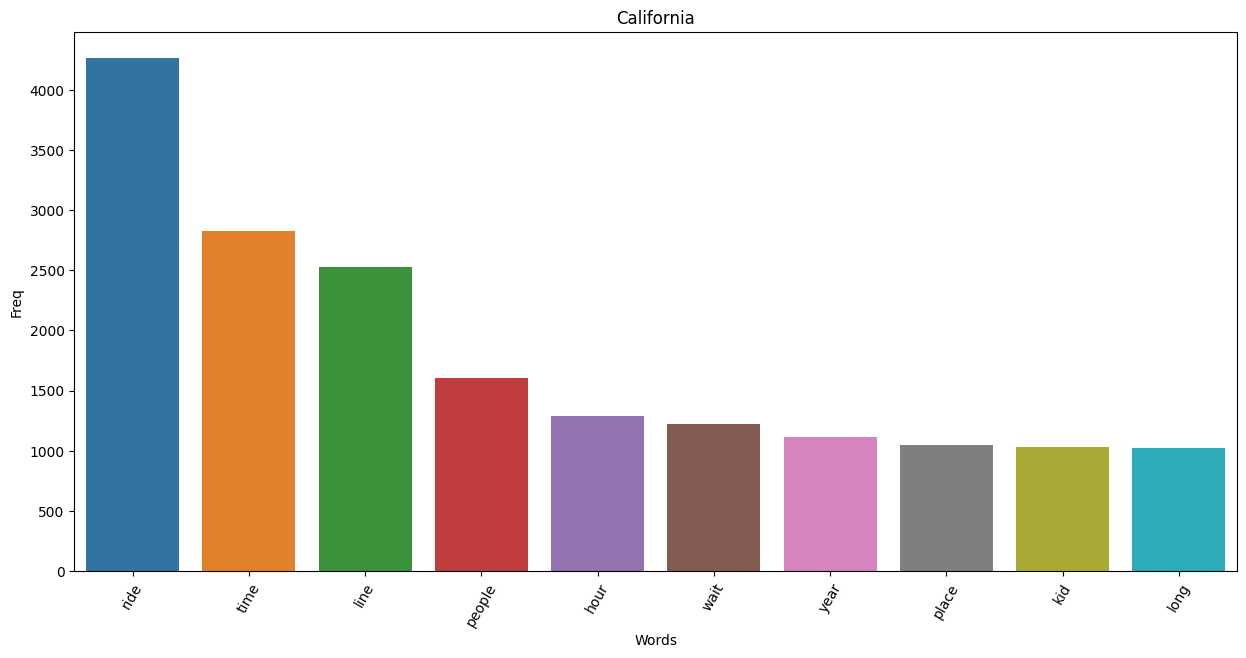

In [ ]:
df_Cal_Neg = df_Cal[df_Cal['Sentiment']=='Negative']
most_common = Counter(' '.join(df_Cal_Neg['EDA_Text']).split()).most_common(10)
mco_df = pd.DataFrame(most_common, columns = ['Words', 'Freq'])
plt.figure(figsize = (15,7))
sns.barplot(data = mco_df, x = 'Words', y = 'Freq')
plt.title('California')
plt.xticks(rotation = 60)
plt.show()

**California**
- 줄이 길고 사람이 많다. → 어느 놀이공원에서나 보이는 기본적인 문제점들만 보유

In [ ]:
# 파리 지점 부정 리뷰 살펴보기
pd.DataFrame(df_Par_Neg[['Review_Text', 'Rating']]).head()

,Review_Text,Rating
29034,"We booked tickets on line for Disneyland, this...",2
29042,After multiple visits to the original Disneyla...,3
29043,Why they selling fastpass tickets without have...,1
29047,We went to Disneyland Paris during the Easter ...,2
29053,Its a shame this park carry the name Disney......,1


**파리 디즈니랜드**

1. 지리적 입지 문제  
프랑스 파리 근교의 날씨는 놀이 공원에 적합하지 않다.  
여름에는 건조하고 겨울에는 비가 많이 내려 습하기 때문이다.

2. 음식 문제  
디즈니사는 놀이공원에서 사람들이 점심을 간단하게 샌드위치나 핫도그 등으로 해결할 것으로 생각했다.  
그러나 프랑스인들은 간단한 것으로 점심을 떼우기보다는 좀더 포멀한 식당을 찾았다.  
이로 인해 식당은 턱없이 부족했고, 이 때문에 기다리는 시간도 오래 걸려 많은 사람들이 불편을 겪게 되었다.